# Statistics 

In [3]:
%cd C:\Users\tenis\OneDrive\Desktop\Data_Projects\Impact_Capital
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score)


C:\Users\tenis\OneDrive\Desktop\Data_Projects\Impact_Capital


In [195]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
df = pd.read_csv('data/processed/data2015.csv')
df.head()
sum(df['Dissolved'])


10175

* **Org Size** uses expenditures divided by 100000 
* **Population** Pop divided by 100000
* **Median Household Income** divided by 10000

### Ratios to measure nonprofit financial flexibility

* **Ratio of equity to total revenue** The implicit assumption is that organizations with a larger networth relative to revenue have a greater ability to replace revenue than those with a smaller or negative net worth. 
* **Ratio Administrative Expenses to total Expenses** Nonprofits with high administrative costs (relative to others in their category) are assumed to have the greatest opportunity to cut back on administrative costs without reducing programs. 

* **Operating Margins** A nonprofit’s operating margin is defined as its revenues less its expenditures, divided by its revenues. This shows the percentage that its net income represents of its revenues. 

* **Solvency** Total net assets to total assets. Calculated by dividing total net assets (total assets minus total liabilities) by total assets. The higher the rating the less likely nonprofit is to default 

* **Profitability** calculating by net income divided by total assets. 

* **Revenue Concentration** Closer to one signifies a nonprofit's revenue stream is concentrated in one resource

* **Resource Dependence Variables**  Dependence are funding source divided by total revenue


### Creating financially vulerable variable (Depdendent Variable)

* Reduction in the ratio of program expenses to total reveune 
* Hager, Galaskiewicz,Bielefeld, and Pins’s 1996 study found that many charities that ceased operations did so primarily for program-related reasons (suchas a reduction of donations or a decreased demand for program services). 


### NTEE Codes
I. Arts, Culture, and Humanities - A </br>
II. Education - B </br>
III. Environment and Animals - C, D </br>
IV. Health - E, F, G, H </br>
V. Human Services - I, J, K, L, M, N, O, P </br>
VI. International, Foreign Affairs - Q </br>
VII. Public, Societal Benefit - R, S, T, U, V, W </br>
VIII. Religion Related - X </br>

# Distribution of total nonprofit expenses. X axis is in billions of dollars 

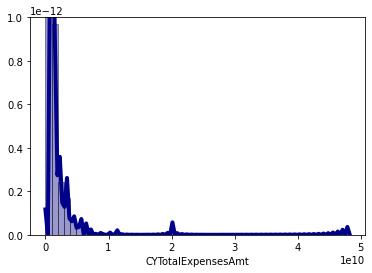

In [28]:
sns.distplot(df['CYTotalExpensesAmt'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Separating dataframes by category 

In [196]:
dfArtsCulture = df[df['recommended'] == "I"]
dfEducation = df[df['recommended'] == "II"]
dfEnviroment_Animals = df[df['recommended'] == "III"]
dfHealth = df[df['recommended'] == "IV"]
dfHumanServices = df[df['recommended'] == "V"]
dfInternational = df[df['recommended'] == "VI"]
dfSocietalBenefit = df[df['recommended'] == "VII"]
dfReligion = df[df['recommended'] == "VIII"]


# Logistic function that allows you to subset by category and remove outliers by percentile 
* It's broken into three parts. The first  includes the revenue diversification variable, and the second uses resource dependence

In [197]:
def logistic(data, low, high):
    "data = the dataframe to be used"
    "low = low end of quintile"
    "high = high end of quintile"
    

    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    
    print("Before removing outliers","\n", data['CYTotalExpensesAmt'].describe(), "\n")
    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    print("After removing outliers","\n", df2015['CYTotalExpensesAmt'].describe(),"\n")
    
    sns.distplot(df2015['CYTotalExpensesAmt'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    
    
    logistic = df2015[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Ratio_ProgramExp_Rev',
                   'Operating_Margin',
                   'Solvency',
                   'Profitability',
                   'Revenue_Concentration',
                   'Population',
                   'Median Household Income', 
                   'Unemployment Rate',
                   'White', 
                   'Black',
                   'Native American',
                   'Asian',
                   'Latino',
                   'Nonprofit Density',
                   'Dissolved'
                     ]]


    #with concentration 
    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['Dissolved'] = logistic['Dissolved'].astype(float)
    X = logistic.loc[:, logistic.columns != 'Dissolved']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'Dissolved']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    THRESHOLD = 0.053
    
    #Fitting model
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train).fit(max_iter=10000)
    print("Using Revenue Concentration", "\n",logit_model.summary2())
    
    #Predicting Values
    y_test=y_test.values.reshape(-1,1)
    yhat = logit_model.predict(X_test) 
    prediction = np.where(yhat > THRESHOLD, 1, 0)
    
           
    
    # confusion matrix 
    cm = confusion_matrix(y_test, prediction)  
    print ("Confusion Matrix \(Diversification\) : \n", cm)  
  
    # accuracy score of the model 
    print('Test accuracy (Diversification) = ', accuracy_score(y_test, prediction))

    
    #With Dependence 
    logistic = df2015[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_ProgramExp_Rev',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Solvency',
                        'Profitability',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        'Population',
                       'Median Household Income', 
                       'Unemployment Rate',
                       'White', 
                       'Black',
                       'Native American',
                       'Asian',
                       'Latino',
                       'Nonprofit Density',
                       'Dissolved'
                     ]]

    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['Dissolved'] = logistic['Dissolved'].astype(float)
    X = logistic.loc[:, logistic.columns != 'Dissolved']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'Dissolved']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #Fitting the model
    y_train=y_train.values.reshape(-1,1)
    logit_model=sm.Logit(y_train,X_train).fit(max_iter=10000)
    print("Using Resource Dependence", "\n",logit_model.summary2())
    
    #Testing for prediction
    y_test=y_test.values.reshape(-1,1)
    yhat = logit_model.predict(X_test) 
    prediction = np.where(yhat > THRESHOLD, 1, 0)
    
    # confusion matrix 
    cm = confusion_matrix(y_test, prediction)  
    print ("Confusion Matrix (Dependence) : \n", cm)  
  
    # accuracy score of the model 
    print('Test accuracy (Dependence) = ', accuracy_score(y_test, prediction))
    
    
    return logit_model

In [12]:
def results_summary_to_dataframe(results):
    '''This takes the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

Before removing outliers 
 count    2.603740e+05
mean     1.092997e+07
std      2.324055e+08
min     -2.507175e+06
25%      1.877908e+05
50%      4.864115e+05
75%      1.794577e+06
max      4.825271e+10
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    2.343170e+05
mean     1.010659e+06
std      1.477930e+06
min      0.000000e+00
25%      1.677670e+05
50%      3.961660e+05
75%      1.140024e+06
max      8.027784e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.170490
         Iterations 9
Using Revenue Concentration 
                              Results: Logit
Model:                Logit              Pseudo R-squared:   0.024      
Dependent Variable:   y                  AIC:                55963.7636 
Date:                 2020-12-05 23:32   BIC:                56143.9031 
No. Observations:     164021             Log-Likelihood:     -27964.    
Df Model:             17                 

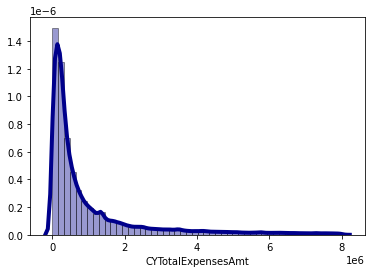

In [198]:
logistic(df, 0.001, .9)

# The full model

In [190]:
NTEE_Code = pd.get_dummies(df.recommended, prefix='NTEE_Code')
df_all= pd.concat([df.reset_index(drop=True), NTEE_Code], axis=1, ignore_index=False)

# Testing for multicollinearity 

In [187]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

testing = df_all[df_all['CYTotalExpensesAmt'].between(
    df_all['CYTotalExpensesAmt'].quantile(0.001),
    df_all['CYTotalExpensesAmt'].quantile(0.9))] # without outliers 


x = testing[['FormationYr',
               'org_size',
               'Ratio_Equity_Revenue',
               'Ratio_AdminExp_Exp',
               'Ratio_ProgramExp_Rev',
               'Operating_Margin',
               'Solvency',
               'Profitability',
               'Revenue_Concentration',
               'Population',
               'Median Household Income', 
               'Unemployment Rate',
               'White', 
               'Black',
               'Native American',
               'Asian',
               'Latino',
               'Nonprofit Density',
               'NTEE_Code_I',
               'NTEE_Code_II',
               'NTEE_Code_III',
               'NTEE_Code_IV',
               'NTEE_Code_IX',
               'NTEE_Code_V',
               'NTEE_Code_VI',
               'NTEE_Code_VII',
               'NTEE_Code_VIII'
                 ]]

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                    feature         VIF
0               FormationYr    1.018088
1                  org_size    1.049173
2      Ratio_Equity_Revenue    1.213878
3      Ratio_ProgramExp_Rev    2.539131
4        Ratio_AdminExp_Exp    1.010669
5          Operating_Margin    2.362751
6                  Solvency    1.012855
7             Profitability    1.012860
8         Dependence_Grants    1.469994
9      Dependence_Campaigns    1.001936
10   Dependence_Memberships    1.020684
11   Dependence_Fundraising    1.450227
12   Dependence_ProgramServ    1.017502
13        Dependence_Invest    1.004862
14               Population    3.507031
15  Median Household Income    2.161390
16        Unemployment Rate    1.837360
17                    White   10.652328
18                    Black    5.486935
19          Native American    1.238901
20                    Asian    3.723215
21                   Latino    6.332324
22        Nonprofit Density    3.243587
23              NTEE_Code_I  184.289257


# Testing for IV's linearly related to the log odds

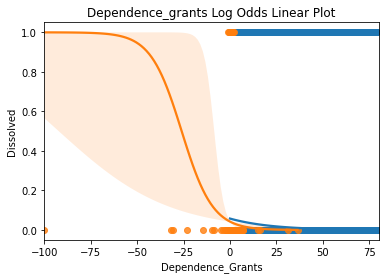

In [188]:
gre = sns.regplot(x= 'org_size', y= 'Dissolved', data= testing, logistic= True).set_title("org_size Log Odds Linear Plot")
gre.figure.savefig("reports/gre log lin.png")

gpa = sns.regplot(x= 'Dependence_Grants', y= 'Dissolved', data= testing, logistic= True).set_title("Dependence_grants Log Odds Linear Plot")
gpa.figure.savefig("reports/gpa log lin.png")

In [209]:
testing = testing[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_ProgramExp_Rev',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Solvency',
                        'Profitability',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        'Population',
                       'Median Household Income', 
                       'Unemployment Rate',
                       'White', 
                       'Black',
                       'Native American',
                       'Asian',
                       'Latino',
                       'Nonprofit Density',
                       'Dissolved'
                     ]]

testing.columns

Index(['FormationYr', 'org_size', 'Ratio_Equity_Revenue',
       'Ratio_ProgramExp_Rev', 'Ratio_AdminExp_Exp', 'Operating_Margin',
       'Solvency', 'Profitability', 'Dependence_Grants',
       'Dependence_Campaigns', 'Dependence_Memberships',
       'Dependence_Fundraising', 'Dependence_ProgramServ', 'Dependence_Invest',
       'Population', 'Median Household Income', 'Unemployment Rate', 'White',
       'Black', 'Native American', 'Asian', 'Latino', 'Nonprofit Density',
       'Dissolved'],
      dtype='object')

In [214]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234317 entries, 0 to 260373
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FormationYr              234317 non-null  int64  
 1   org_size                 234317 non-null  float64
 2   Ratio_Equity_Revenue     234317 non-null  float64
 3   Ratio_ProgramExp_Rev     234317 non-null  float64
 4   Ratio_AdminExp_Exp       234317 non-null  float64
 5   Operating_Margin         234317 non-null  float64
 6   Solvency                 234317 non-null  float64
 7   Profitability            234317 non-null  float64
 8   Dependence_Grants        234317 non-null  float64
 9   Dependence_Campaigns     234317 non-null  float64
 10  Dependence_Memberships   234317 non-null  float64
 11  Dependence_Fundraising   234317 non-null  float64
 12  Dependence_ProgramServ   234317 non-null  float64
 13  Dependence_Invest        234317 non-null  float64
 14  Popu

In [205]:
for i, col in enumerate(testing.columns):
    print(col)

FormationYr
org_size
Ratio_Equity_Revenue
Ratio_ProgramExp_Rev
Ratio_AdminExp_Exp
Operating_Margin
Solvency
Profitability
Dependence_Grants
Dependence_Campaigns
Dependence_Memberships
Dependence_Fundraising
Dependence_ProgramServ
Dependence_Invest
Population
Median Household Income
Unemployment Rate
White
Black
Native American
Asian
Latino
Nonprofit Density
Dissolved


In [218]:
df1 = testing[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_ProgramExp_Rev',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Solvency',
                        'Profitability',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        'Population',
                       'Median Household Income', 
                       'Unemployment Rate',
                       'White', 
                       'Black',
                       'Native American',
                       'Asian',
                       'Latino',
                       'Nonprofit Density'
                     ]]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234317 entries, 0 to 260373
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FormationYr              234317 non-null  int64  
 1   org_size                 234317 non-null  float64
 2   Ratio_Equity_Revenue     234317 non-null  float64
 3   Ratio_ProgramExp_Rev     234317 non-null  float64
 4   Ratio_AdminExp_Exp       234317 non-null  float64
 5   Operating_Margin         234317 non-null  float64
 6   Solvency                 234317 non-null  float64
 7   Profitability            234317 non-null  float64
 8   Dependence_Grants        234317 non-null  float64
 9   Dependence_Campaigns     234317 non-null  float64
 10  Dependence_Memberships   234317 non-null  float64
 11  Dependence_Fundraising   234317 non-null  float64
 12  Dependence_ProgramServ   234317 non-null  float64
 13  Dependence_Invest        234317 non-null  float64
 14  Popu

C:\Users\tenis\anaconda3\lib\site-packages\numpy\core\function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\tenis\anaconda3\lib\site-packages\numpy\core\function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start


MissingDataError: exog contains inf or nans

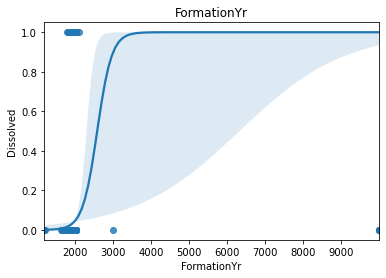

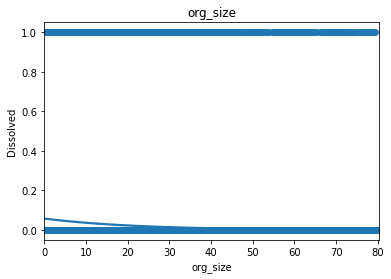

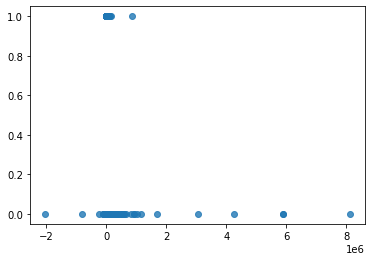

In [219]:


for i, col in enumerate(df1.columns):
    plt.figure(i)
    name= col
    var = sns.regplot(x= col, y= 'Dissolved',
                      data= testing, logistic= True).set_title(name)
    save = "reports/" + name + "_linearity.png"
    var.figure.savefig(save)

In [184]:
def logistic_full(data, low, high):
    "data = the dataframe to be used"
    "low = low end of quintile"
    "high = high end of quintile"
    

    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    
    print("Before removing outliers","\n", data['CYTotalExpensesAmt'].describe(), "\n")
    df2015 = data[data['CYTotalExpensesAmt'].between(data['CYTotalExpensesAmt'].quantile(low), data['CYTotalExpensesAmt'].quantile(high))] # without outliers
    print("After removing outliers","\n", df2015['CYTotalExpensesAmt'].describe(),"\n")
    
    
    print(sns.distplot(df2015['CYTotalExpensesAmt'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}))
    
    
    logistic = df2015[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Ratio_ProgramExp_Rev',
                   'Operating_Margin',
                   'Solvency',
                   'Profitability',
                   'Revenue_Concentration',
                   'Population',
                   'Median Household Income', 
                   'Unemployment Rate',
                   'White', 
                   'Black',
                   'Native American',
                   'Asian',
                   'Latino',
                   'Nonprofit Density',
                   'NTEE_Code_I',
                   'NTEE_Code_II',
                   'NTEE_Code_III',
                   'NTEE_Code_IV',
                   'NTEE_Code_IX',
                   'NTEE_Code_V',
                   'NTEE_Code_VI',
                   'NTEE_Code_VII',
                   'NTEE_Code_VIII',
                   'Dissolved'
                     ]]


    #with concentration 
    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['Dissolved'] = logistic['Dissolved'].astype(float)
    X = logistic.loc[:, logistic.columns != 'Dissolved']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'Dissolved']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27,stratify=y)
    y_train=y_train.values.reshape(-1,1)
    THRESHOLD = 0.05
    
    #Fitting model 
    logit_model=sm.Logit(y_train,X_train).fit(max_iter=10000)
    print("Using Revenue Concentration", "\n",logit_model.summary2())
    
    #Predicting Values
    y_test=y_test.values.reshape(-1,1)
    yhat = logit_model.predict(X_test) 
    prediction = np.where(yhat > THRESHOLD, 1, 0)

    # confusion matrix 
    cm = confusion_matrix(y_test, prediction)  
    print ("Confusion Matrix (Diversification) : \n", cm)  
  
    # accuracy score of the model 
    print('Test accuracy (Diversification) = ', accuracy_score(y_test, prediction))
    
    #With Dependence 
    logistic = df2015[['FormationYr',
                        'org_size',
                        #'Ratio_Equity_Revenue',
                        #'Ratio_ProgramExp_Rev',
                        'Ratio_AdminExp_Exp',
                        #'Operating_Margin',
                        'Solvency',
                        'Profitability',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        'Population',
                       'Median Household Income', 
                       #'Unemployment Rate',
                       'White', 
                       'Black',
                       'Native American',
                       'Asian',
                       'Latino',
                       'Nonprofit Density',
                       #'NTEE_Code_I',
                       #'NTEE_Code_II',
                       #'NTEE_Code_III',
                       #'NTEE_Code_IV',
                       #'NTEE_Code_IX',
                       #'NTEE_Code_V',
                       #'NTEE_Code_VI',
                       #'NTEE_Code_VII',
                       #'NTEE_Code_VIII',
                       'Dissolved'
                     ]]

    logistic = logistic.replace([np.inf, -np.inf], np.nan)
    logistic = logistic.fillna(0)
    logistic['Dissolved'] = logistic['Dissolved'].astype(float)
    X = logistic.loc[:, logistic.columns != 'Dissolved']
    X_colnames = X.columns
    X = pd.DataFrame(X, columns = X_colnames)
    y = logistic.loc[:, logistic.columns == 'Dissolved']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
    y_train=y_train.values.reshape(-1,1)
    
    #Fitting model
    logit_model=sm.Logit(y_train,X_train).fit(max_iter=10000)
    print("Using Resource Dependence", "\n",logit_model.summary2())
    
    #Predicting Values
    y_test=y_test.values.reshape(-1,1)
    yhat = logit_model.predict(X_test) 
    prediction = np.where(yhat > THRESHOLD, 1, 0)
    
    # confusion matrix 
    cm = confusion_matrix(y_test, prediction)  
    print ("Confusion Matrix (Dependence) : \n", cm)  
  
    # accuracy score of the model 
    print('Test accuracy (Dependence) = ', accuracy_score(y_test, prediction))
    
    return

Before removing outliers 
 count    2.603740e+05
mean     1.092997e+07
std      2.324055e+08
min     -2.507175e+06
25%      1.877908e+05
50%      4.864115e+05
75%      1.794577e+06
max      4.825271e+10
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    2.343170e+05
mean     1.010659e+06
std      1.477930e+06
min      0.000000e+00
25%      1.677670e+05
50%      3.961660e+05
75%      1.140024e+06
max      8.027784e+06
Name: CYTotalExpensesAmt, dtype: float64 

Optimization terminated successfully.
         Current function value: 0.169849
         Iterations 9
Using Revenue Concentration 
                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.027     
Dependent Variable:    y                   AIC:                 63731.4001
Date:                  2020-12-05 16:36    BIC:                 64005.2148
No. Observations:      187453              Log-Likelihood:      -31839.   
Df Model:              26       

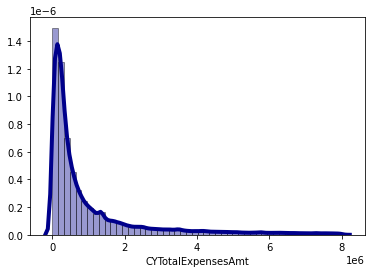

In [85]:
logistic_full(df_all, 0.0001, .9)

Before removing outliers 
 count    2.603740e+05
mean     1.092997e+07
std      2.324055e+08
min     -2.507175e+06
25%      1.877908e+05
50%      4.864115e+05
75%      1.794577e+06
max      4.825271e+10
Name: CYTotalExpensesAmt, dtype: float64 

After removing outliers 
 count    2.343170e+05
mean     1.010659e+06
std      1.477930e+06
min      0.000000e+00
25%      1.677670e+05
50%      3.961660e+05
75%      1.140024e+06
max      8.027784e+06
Name: CYTotalExpensesAmt, dtype: float64 

AxesSubplot(0.125,0.125;0.775x0.755)
Optimization terminated successfully.
         Current function value: 0.169849
         Iterations 9
Using Revenue Concentration 
                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.027     
Dependent Variable:    y                   AIC:                 63731.4001
Date:                  2020-12-05 22:18    BIC:                 64005.2148
No. Observations:      187453              Log-Likelihood:      -31839

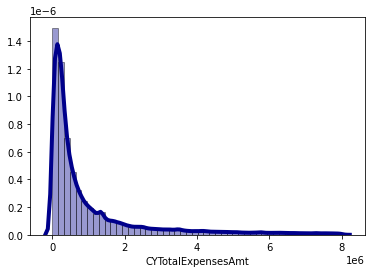

In [185]:
logistic_full(df_all, 0.0001, .9)

# Random Forest 

In [131]:
from sklearn.ensemble import RandomForestClassifier

df_rf = df_all

df_rf = df_rf[df_rf['CYTotalExpensesAmt'].between(
    df_rf['CYTotalExpensesAmt'].quantile(0.001),
    df_rf['CYTotalExpensesAmt'].quantile(0.9))] # without outliers 

df_rf = df_rf[['FormationYr',
                   'org_size',
                   'Ratio_Equity_Revenue',
                   'Ratio_AdminExp_Exp',
                   'Ratio_ProgramExp_Rev',
                   'Operating_Margin',
                   'Solvency',
                   'Profitability',
                   'Revenue_Concentration',
                   'Population',
                   'Median Household Income', 
                   'Unemployment Rate',
                   'White', 
                   'Black',
                   'Native American',
                   'Asian',
                   'Latino',
                   'Nonprofit Density',
                   'NTEE_Code_I',
                   'NTEE_Code_II',
                   'NTEE_Code_III',
                   'NTEE_Code_IV',
                   'NTEE_Code_IX',
                   'NTEE_Code_V',
                   'NTEE_Code_VI',
                   'NTEE_Code_VII',
                   'NTEE_Code_VIII',
                   'Dissolved'
                     ]]

 

df_rf = df_rf.replace([np.inf, -np.inf], np.nan)
df_rf = df_rf.fillna(0)
df_rf['Dissolved'] = df_rf['Dissolved'].astype(float)
X = df_rf.loc[:, df_rf.columns != 'Dissolved']
X_colnames = X.columns
X = pd.DataFrame(X, columns = X_colnames)
y = df_rf.loc[:, df_rf.columns == 'Dissolved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)

    

In [132]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train.ravel())


y_pred=clf.predict_proba(X_test)


In [133]:
threshold = 0.05
predicted = (y_pred [:,1] >= threshold).astype('int')

In [134]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Accuracy: 0.6715815978149539


In [135]:
feature_imp = pd.Series(clf.feature_importances_,index=list(X.columns)).sort_values(ascending=False)
feature_imp

org_size                   0.087436
Profitability              0.082772
Ratio_Equity_Revenue       0.074997
Operating_Margin           0.068580
Revenue_Concentration      0.064031
Ratio_ProgramExp_Rev       0.060725
FormationYr                0.053993
Solvency                   0.052237
Ratio_AdminExp_Exp         0.051914
Unemployment Rate          0.044234
Median Household Income    0.042952
Population                 0.040616
Black                      0.040537
White                      0.040441
Latino                     0.040381
Nonprofit Density          0.040192
Asian                      0.036383
Native American            0.025094
NTEE_Code_V                0.010131
NTEE_Code_VII              0.008208
NTEE_Code_II               0.007678
NTEE_Code_IV               0.007059
NTEE_Code_I                0.005735
NTEE_Code_VIII             0.003819
NTEE_Code_III              0.003814
NTEE_Code_IX               0.003507
NTEE_Code_VI               0.002533
dtype: float64

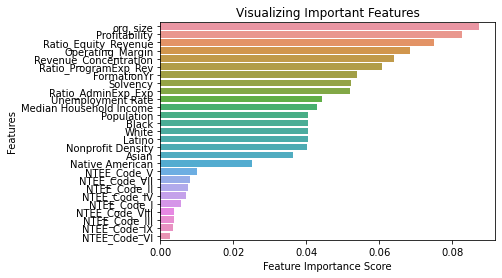

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

[[30039 14852]
 [  539  1434]]


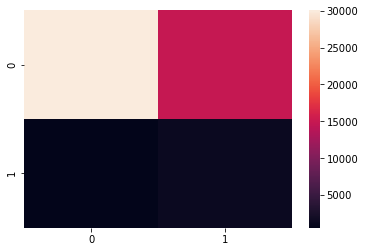

In [137]:
conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)

sns.heatmap(conf_mat)
plt.show()

# Dependence 


In [139]:
df_rf = df_all

df_rf = df_rf[df_rf['CYTotalExpensesAmt'].between(
    df_rf['CYTotalExpensesAmt'].quantile(0.001),
    df_rf['CYTotalExpensesAmt'].quantile(0.9))] # without outliers 

df_rf = df_rf[['FormationYr',
                        'org_size',
                        'Ratio_Equity_Revenue',
                        'Ratio_ProgramExp_Rev',
                        'Ratio_AdminExp_Exp',
                        'Operating_Margin',
                        'Solvency',
                        'Profitability',
                        'Dependence_Grants',
                        'Dependence_Campaigns',
                        'Dependence_Memberships',
                        'Dependence_Fundraising', 
                        'Dependence_ProgramServ',
                        'Dependence_Invest',
                        'Population',
                       'Median Household Income', 
                       'Unemployment Rate',
                       'White', 
                       'Black',
                       'Native American',
                       'Asian',
                       'Latino',
                       'Nonprofit Density',
                       'NTEE_Code_I',
                       'NTEE_Code_II',
                       'NTEE_Code_III',
                       'NTEE_Code_IV',
                       'NTEE_Code_IX',
                       'NTEE_Code_V',
                       'NTEE_Code_VI',
                       'NTEE_Code_VII',
                       'NTEE_Code_VIII',
                       'Dissolved'
                     ]]

 
df_rf = df_rf.replace([np.inf, -np.inf], np.nan)
df_rf = df_rf.fillna(0)
df_rf['Dissolved'] = df_rf['Dissolved'].astype(float)
X = df_rf.loc[:, df_rf.columns != 'Dissolved']
X_colnames = X.columns
X = pd.DataFrame(X, columns = X_colnames)
y = df_rf.loc[:, df_rf.columns == 'Dissolved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train.ravel())


y_pred=clf.predict_proba(X_test)


In [146]:
test_y = pd.DataFrame(y_test)
test_X = pd.DataFrame(X_test)


In [152]:
#Formatting for ROC curve
y_pred_prob = pd.DataFrame(y_pred)
y_1_prob = y_pred_prob[1]
y_test_1 = test_y.reset_index()

y_test_1 = y_test_1.rename(columns={0: 'Dissolution'})
y_test_1 = y_test_1['Dissolution']
X_test = test_X.reset_index()

In [ ]:
df = pd.DataFrame({'y_test': y_test_1, 'model_probability': y_1_prob})

In [162]:
#Forming new df for ROC Curve and Accuracy curve
df = pd.DataFrame({'y_test': y_test_1, 'model_probability': y_1_prob})
df = df.sort_values('model_probability')
#Creating 'True Positive', 'False Positive', 'True Negative' and 'False Negative' columns 
df['tp'] = (df['y_test'] == int(0)).cumsum()
df['fp'] = (df['y_test'] == int(1)).cumsum()
total_0s = df['y_test'].sum()
total_1s = abs(total_0s - len(df))
df['total_1s'] = total_1s
df['total_0s']= total_0s
df['total_instances'] = df['total_1s'] + df['total_0s']
df['tn'] = df['total_0s'] - df['fp']
df['fn'] = df['total_1s'] - df['tp']
df['fp_rate'] = df['fp'] / df['total_0s']
df['tp_rate'] = df['tp'] / df['total_1s']
df['tn_rate'] = df['tn'] / df['total_0s']
#Calculating accuracy column
df['accuracy'] = (df['tp'] + df['tn']) / (df['total_1s'] + df['total_0s'])
#Deleting unnecessary columns
df.reset_index(inplace = True)
del df['total_1s']
del df['total_0s']
del df['total_instances']
del df['index']
#Export the log into excel to show your friends
#export_excel = df.to_excel (r"C:\Users\Andrew\Desktop\df1.xlsx", index = None, header=True)

In [163]:
df

,y_test,model_probability,tp,fp,tn,fn,fp_rate,tp_rate,tn_rate,accuracy
0,0.0,0.00,1,0,1973.0,44890.0,0.000000,0.000022,1.000000,0.042122
1,0.0,0.00,2,0,1973.0,44889.0,0.000000,0.000045,1.000000,0.042143
2,0.0,0.00,3,0,1973.0,44888.0,0.000000,0.000067,1.000000,0.042165
3,0.0,0.00,4,0,1973.0,44887.0,0.000000,0.000089,1.000000,0.042186
4,0.0,0.00,5,0,1973.0,44886.0,0.000000,0.000111,1.000000,0.042207
5,0.0,0.00,6,0,1973.0,44885.0,0.000000,0.000134,1.000000,0.042229
6,0.0,0.00,7,0,1973.0,44884.0,0.000000,0.000156,1.000000,0.042250
7,0.0,0.00,8,0,1973.0,44883.0,0.000000,0.000178,1.000000,0.042271
8,0.0,0.00,9,0,1973.0,44882.0,0.000000,0.000200,1.000000,0.042293
9,0.0,0.00,10,0,1973.0,44881.0,0.000000,0.000223,1.000000,0.042314


Text(0.5, 1.0, 'Optimal Cutoff')

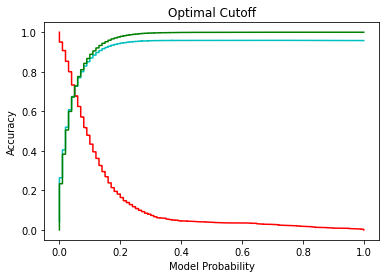

In [173]:
#Plot
plt.plot(df['model_probability'],df['accuracy'], color = 'c')
plt.plot(df['model_probability'],df['tn_rate'], color = 'r')
plt.plot(df['model_probability'],df['tp_rate'], color = 'g')
plt.xlabel('Model Probability')
plt.ylabel('Accuracy')
plt.title('Optimal Cutoff')

In [180]:
idx = np.argwhere(np.diff(np.sign(df['accuracy'] - df['tn_rate']))).flatten()
idx

df.iloc[32077, :]


y_test                      0
model_probability        0.05
tp                      31489
fp                        589
tn                       1384
fn                      13402
fp_rate               0.29853
tp_rate              0.701455
tn_rate               0.70147
accuracy             0.701455
comparison_column       False
Name: 32077, dtype: object

Accuracy: 0.6750597473540457
org_size                   0.079667
Profitability              0.074424
Ratio_Equity_Revenue       0.066133
Operating_Margin           0.062339
Ratio_ProgramExp_Rev       0.054104
FormationYr                0.049081
Ratio_AdminExp_Exp         0.046895
Solvency                   0.046718
Dependence_Invest          0.043914
Median Household Income    0.041262
Unemployment Rate          0.041189
Latino                     0.039210
White                      0.038790
Black                      0.038786
Population                 0.038693
Nonprofit Density          0.038669
Dependence_ProgramServ     0.037548
Asian                      0.035431
Native American            0.023904
Dependence_Memberships     0.017171
Dependence_Grants          0.016515
Dependence_Fundraising     0.014467
NTEE_Code_V                0.009478
NTEE_Code_VII              0.007620
NTEE_Code_II               0.007049
NTEE_Code_IV               0.006546
Dependence_Campaigns       0.006170

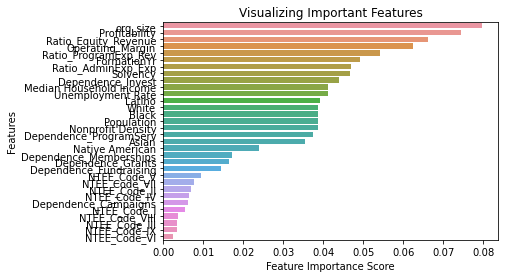

In [140]:

threshold = 0.05
predicted = (y_pred [:,1] >= threshold).astype('int')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

feature_imp = pd.Series(clf.feature_importances_,index=list(X.columns)).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

[[30190 14701]
 [  527  1446]]


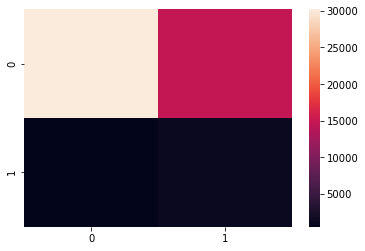

In [141]:
conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)

sns.heatmap(conf_mat)
plt.show()